In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
def entropy(p):
    """
    Calculate the entropy for a given probability distribution.

    Parameters:
        p (list): List of probabilities for different categories.

    Returns:
        float: Entropy value.
    """
    entropy_value = -np.sum([pi * np.log2(pi) for pi in p if pi > 0])
    return entropy_value

def variation_ratio(p):
    """
    Calculate the variation ratio for a given probability distribution.

    Parameters:
        p (list): List of probabilities for different categories.

    Returns:
        float: Variation ratio value.
    """
    max_p = max(p)
    variation_ratio_value = 1 - max_p
    return variation_ratio_value

# Example usage:
p1 = [0.5, 0.5]
p2 = [1.0, 0.0]

entropy_p1 = entropy(p1)
entropy_p2 = entropy(p2)

variation_ratio_p1 = variation_ratio(p1)
variation_ratio_p2 = variation_ratio(p2)

print(f'Entropy of p1: {entropy_p1}')
print(f'Entropy of p2: {entropy_p2}')

print(f'Variation ratio of p1: {variation_ratio_p1}')
print(f'Variation ratio of p2: {variation_ratio_p2}')


Entropy of p1: 1.0
Entropy of p2: -0.0
Variation ratio of p1: 0.5
Variation ratio of p2: 0.0


In [3]:
def vote_entropy(votes):
    """
    Calculate the vote entropy for a given vote vector.

    Parameters:
        votes (list): List of votes for different categories.

    Returns:
        float: Vote entropy value.
    """
    total_votes = sum(votes)
    vote_probabilities = [vote / total_votes for vote in votes if vote > 0]
    vote_entropy_value = -sum([p * np.log2(p) for p in vote_probabilities])
    return vote_entropy_value

def qbc_vote_vector(predictions):
    """
    Create the vote vector for the given predictions from different models.

    Parameters:
        predictions (list): List of predictions from different models. Each prediction is a category.

    Returns:
        list: Vote vector.
    """
    flattened_predictions = [item for sublist in predictions for item in sublist]
    num_categories = max(flattened_predictions) + 1
    vote_vector = [flattened_predictions.count(category) for category in range(num_categories)]
    return vote_vector

# Example usage:
predictions_ensemble = [
    [0, 1, 1, 0, 1],  # Model 1's predictions
    [1, 1, 0, 0, 1],  # Model 2's predictions
    [0, 1, 0, 1, 1],  # Model 3's predictions
]

vote_vector = qbc_vote_vector(predictions_ensemble)
print(f'Vote vector: {vote_vector}')  # Output: Vote vector: [1, 3, 1]

vote_entropy_value = vote_entropy(vote_vector)
print(f'Vote entropy: {vote_entropy_value}')


Vote vector: [6, 9]
Vote entropy: 0.9709505944546686


In [4]:
def monte_carlo_dropout_predictions(model, x, T):
    """
    Generate predictions using Monte Carlo Dropout.

    Parameters:
        model (tensorflow.keras.Model): Bayesian-style model with Dropout layers.
        x (numpy.array): Input data for which predictions are generated.
        T (int): Number of Monte Carlo samples (dropout runs).

    Returns:
        numpy.array: Monte Carlo dropout predictions for each input sample.
    """
    mc_dropout_predictions = np.zeros((T, x.shape[0], model.output_shape[-1]))

    for t in range(T):
        predictions = model.predict(x)
        mc_dropout_predictions[t] = predictions

    return mc_dropout_predictions

def entropy_uncertainty(mc_dropout_predictions):
    """
    Calculate the uncertainty using the Entropy acquisition function.

    Parameters:
        mc_dropout_predictions (numpy.array): Monte Carlo dropout predictions.

    Returns:
        numpy.array: Uncertainty (Entropy) for each input sample.
    """
    average_predictions = np.mean(mc_dropout_predictions, axis=0)
    entropy_values = -np.sum(average_predictions * np.log2(average_predictions), axis=1)

    return entropy_values


In [5]:
def create_bayesian_model(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout layer for uncertainty estimation
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Load MNIST dataset
(input_train, label_train), (input_test, label_test) = mnist.load_data()

# Normalize the input data and add channel dimension
input_train = input_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
input_test = input_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

input_shape = (28, 28, 1)  # Image shape for MNIST dataset
num_classes = 10  # Number of classes for the MNIST dataset

bayesian_model = create_bayesian_model(input_shape, num_classes)

# Compile the model
bayesian_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Print model summary
bayesian_model.summary()

# Example usage:
T = 100
mc_dropout_predictions = monte_carlo_dropout_predictions(bayesian_model, input_test[:100], T)
uncertainty_values = entropy_uncertainty(mc_dropout_predictions)

print("Monte Carlo Dropout Predictions:")
for i in range(10):
    print(f"Sample {i+1}: {mc_dropout_predictions[:, i]}")

# Print Uncertainty values for the first few test samples
print("\nUncertainty Values:")
for i in range(10):
    print(f"Sample {i+1}: {uncertainty_values[i]}")


11490434/11490434 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                         

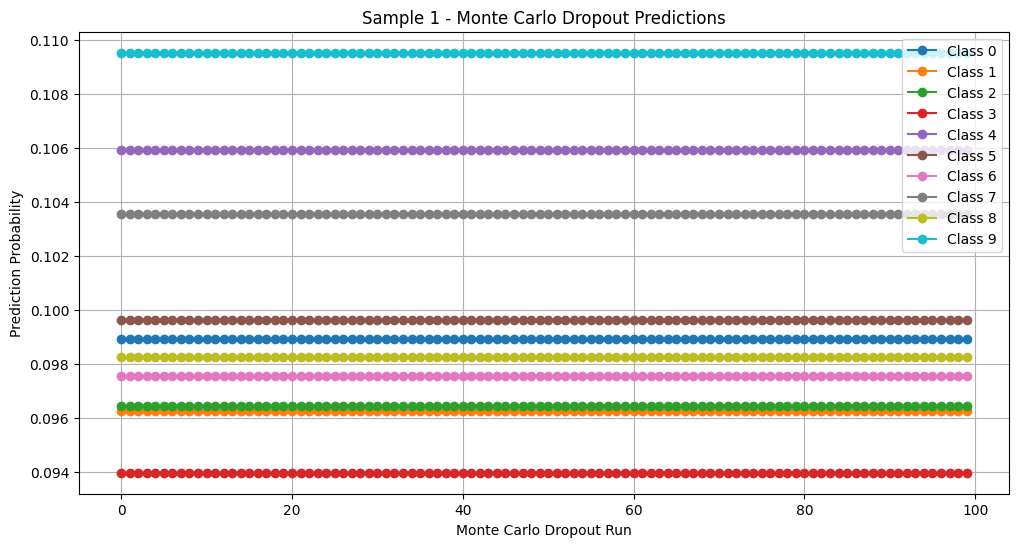

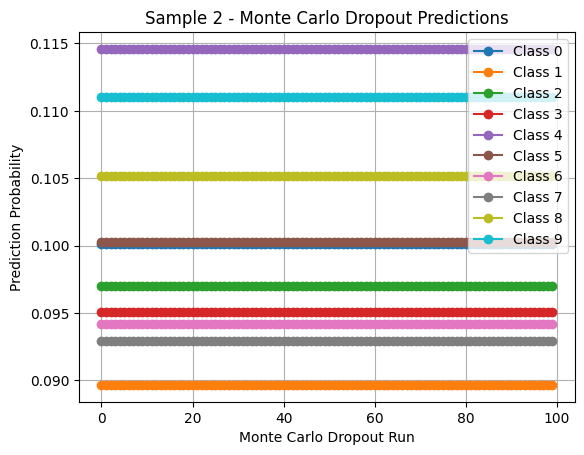

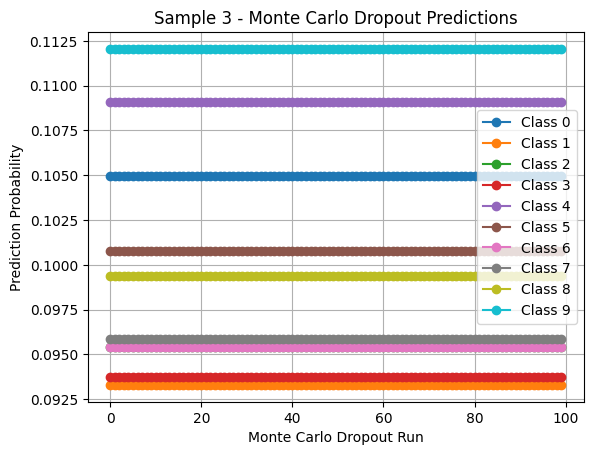

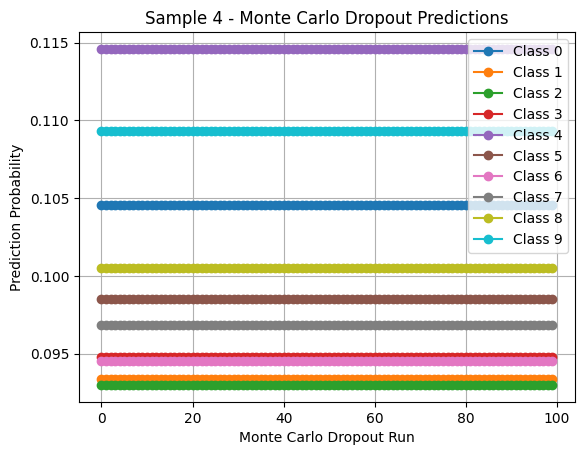

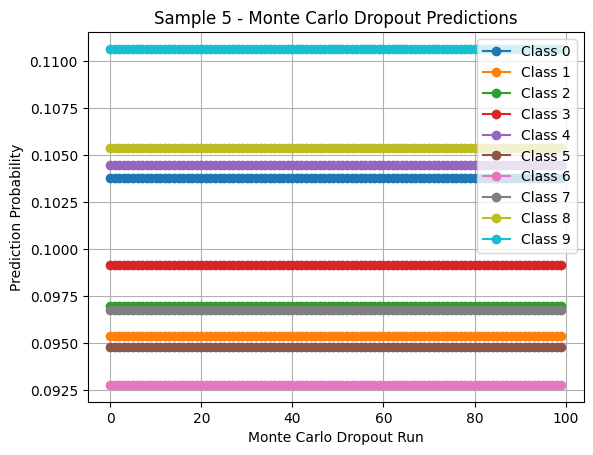

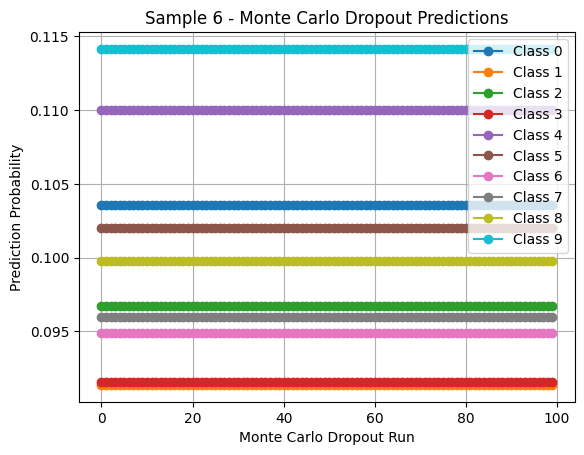

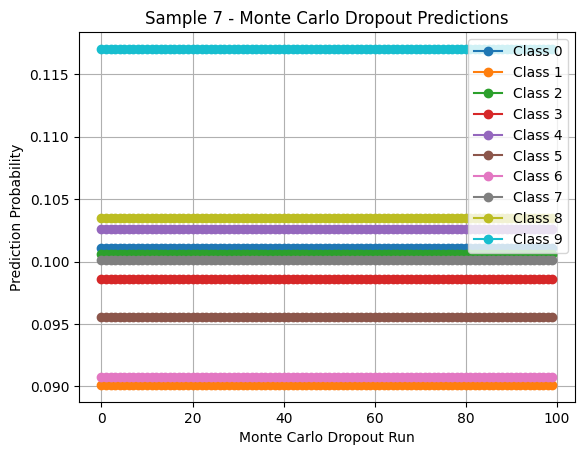

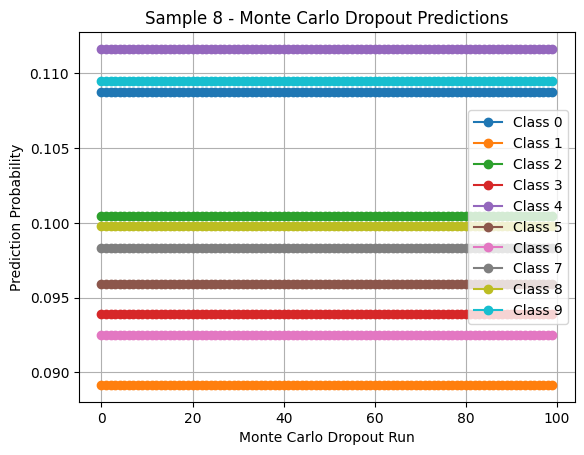

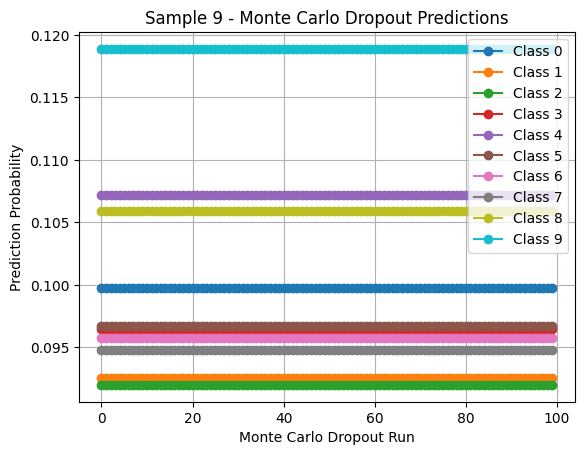

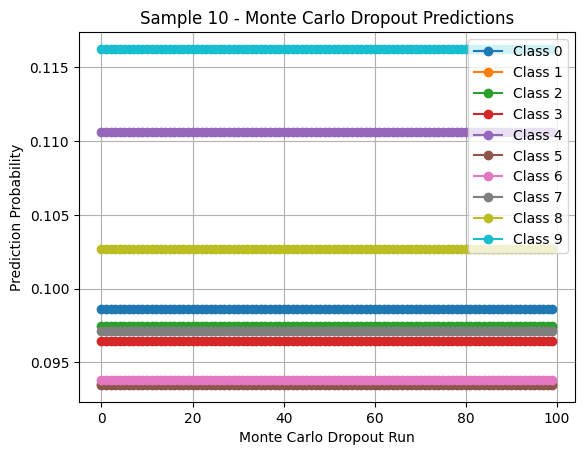

In [6]:
# Plot Monte Carlo Dropout predictions for each sample
num_samples = 10
T = mc_dropout_predictions.shape[0]  # Number of dropout runs

plt.figure(figsize=(12, 6))

for i in range(num_samples):
    sample_predictions = mc_dropout_predictions[:, i, :]
    for j in range(sample_predictions.shape[1]):
        plt.plot(range(T), sample_predictions[:, j], marker='o', label=f'Class {j}')
    plt.xlabel('Monte Carlo Dropout Run')
    plt.ylabel('Prediction Probability')
    plt.title(f'Sample {i + 1} - Monte Carlo Dropout Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def initialize_clusters(data, k):
    centers = [data[np.random.randint(0, len(data))]]
    distances = [0] * len(data)

    for _ in range(1, k):
        sum_distances = 0
        for i, point in enumerate(data):
            distances[i] = min([euclidean_distance(point, center) for center in centers])
            sum_distances += distances[i]

        sum_distances *= np.random.random()
        for i, d in enumerate(distances):
            sum_distances -= d
            if sum_distances > 0:
                continue
            centers.append(data[i])
            break

    return centers

def kmeans(data, k, max_iterations=100):
    centers = initialize_clusters(data, k)

    for _ in range(max_iterations):
        clusters = [[] for _ in range(k)]
        for point in data:
            distances = [euclidean_distance(point, center) for center in centers]
            cluster_idx = np.argmin(distances)
            clusters[cluster_idx].append(point)

        new_centers = []
        for cluster in clusters:
            new_center = np.mean(cluster, axis=0)
            new_centers.append(new_center)

        new_centers = np.array(new_centers)

        if np.allclose(centers, new_centers):
            break

        centers = new_centers

    return centers, clusters

# Generate random data points
np.random.seed(42)
data = np.random.rand(100, 2)

# Number of clusters (K)
k = 3

# Run K-means clustering
centers, clusters = kmeans(data, k)

# Print cluster centers and data points in each cluster
print("Cluster Centers:")
print(centers)

for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1} - Number of data points: {len(cluster)}")
    print(cluster)


Cluster Centers:
[[0.8039633  0.57026999]
 [0.36376248 0.20008043]
 [0.18520943 0.72228065]]
Cluster 1 - Number of data points: 38
[array([0.73199394, 0.59865848]), array([0.60111501, 0.70807258]), array([0.83244264, 0.21233911]), array([0.96563203, 0.80839735]), array([0.68423303, 0.44015249]), array([0.96958463, 0.77513282]), array([0.93949894, 0.89482735]), array([0.59789998, 0.92187424]), array([0.82873751, 0.35675333]), array([0.77224477, 0.19871568]), array([0.70685734, 0.72900717]), array([0.86310343, 0.62329813]), array([0.72960618, 0.63755747]), array([0.88721274, 0.47221493]), array([0.76078505, 0.5612772 ]), array([0.77096718, 0.4937956 ]), array([0.90756647, 0.24929223]), array([0.92969765, 0.80812038]), array([0.63340376, 0.87146059]), array([0.80367208, 0.18657006]), array([0.892559  , 0.53934224]), array([0.80744016, 0.8960913 ]), array([0.81801477, 0.86073058]), array([0.9429097 , 0.32320293]), array([0.51879062, 0.70301896]), array([0.96244729, 0.2517823 ]), array([0.6